In [1]:
import cv2
from mpl_toolkits.mplot3d import Axes3D
import logging
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcol
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.lines import Line2D
from math import pow , sqrt, atan2
import math
import pywt
from scipy.signal import find_peaks
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
sns.set(color_codes=True)
from sklearn.manifold import LocallyLinearEmbedding
from sklearn import manifold, datasets
from scipy.signal import argrelextrema
from scipy.spatial.distance import pdist
from scipy.stats.mstats import pearsonr, spearmanr
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn import metrics
Axes3D


mpl_toolkits.mplot3d.axes3d.Axes3D

# Functions

In [66]:
# Calculate the Residual variance with original dataset and LLE or HLLE dataset

def res_var(X_origi, X_transfo):
    #X_origi   = original dataset
    #X_transfo = modified dataset
    
    #pairwise euclidean distance
    Dx = pdist(X_origi, 'euclidean')
    Dy = pdist(X_transfo, 'euclidean')

    #Pearson correlation
    pxy, _ = pearsonr(Dx, Dy)

    #residual variance
    res_var = 1 - pxy**2
    
    return res_var
# Calculate the Spearman's rho coeff with original dataset and LLE or HLLE dataset
def SpearsmansRho (X_origi, X_transfo):
    #X_origi   = original dataset
    #X_transfo = modified dataset
    
    nbrs = NearestNeighbors(n_neighbors=15, algorithm='ball_tree').fit(X_origi)
    dist, _ = nbrs.kneighbors(X_origi)

    nbrs2 = NearestNeighbors(n_neighbors=15, algorithm='ball_tree').fit(X_transfo)
    dist2, _ = nbrs2.kneighbors(X_transfo)

    dist  = np.delete(dist, 0, 1)
    dist2 = np.delete(dist2, 0, 1)
    coef, p = spearmanr(dist, dist2,axis=None)
    return  np.mean(coef)

# find best number of neighbor
def num_neigh(Data,dim, meth):
    SP_Rho_vect=[]
    Residual_var_vect=[]
    N_Neigh_Max = 35
    NCOMP       = dim
    if meth == "standard":
        nmin = NCOMP+1
        Vect_N      = np.arange(nmin,N_Neigh_Max,1)
    if meth == "hessian":
        nmin =round(NCOMP*(NCOMP+3)/2)+2
        Vect_N      = np.arange( nmin,N_Neigh_Max,1)
    Tot_Err     = []
    for j in range(nmin):
        SP_Rho_vect.append(0)
        Residual_var_vect.append(0)
    for i in Vect_N:
        DataTransfo, err = manifold.locally_linear_embedding(Data, n_neighbors=i,n_components=NCOMP,method = meth)
        Tot_Err.append(err)
        SP_Rho_vect.append(SpearsmansRho(DataTransfo,Data))
        Residual_var_vect.append(res_var(Data,DataTransfo))

    Tot_err = np.array(Tot_Err)
    maxval_SP =max(SP_Rho_vect[nmin:]) 
    indicemax_SP = SP_Rho_vect.index(maxval_SP)
    minval_SP =min(SP_Rho_vect[nmin:]) 
    indicemin_SP = SP_Rho_vect.index(minval_SP)
    combin = np.array(SP_Rho_vect) * np.array(Residual_var_vect)
    max_combi =max(combin[nmin:])
    min_combi =min(combin[nmin:])

    best_N = np.where(combin == max(combin[nmin:]))
    best_N=best_N[0][0]
    worst_N = np.where(combin == min(combin[nmin:]))
    worst_N=worst_N[0][0]
    plt.figure(meth,figsize=(8, 8))
    plt.title( "Plot of the sprearmans'Rho and classification rate")
    plt.xlabel("Number of Neighbor")
    plt.ylabel("Values")
    plt.plot (SP_Rho_vect,color ="red",label="Spearman's Rho")
    plt.plot (Residual_var_vect,color ="yellow",label="residual variance")
    plt.plot(combin,color ="orange",label="Spearman's Rho* residual variance")

    plt.plot (best_N,max_combi,"go",color ="green",label="max Spearman's Rho*residual variance")
    plt.plot (worst_N,min_combi,"go",color ="red",label="min Spearman's Rho*residual variance")

    plt.legend(loc ="lower left")
    plt.text(20,0,"worst K = "+ str(worst_N) +" and best K = " + str(best_N))
    return best_N,worst_N




# TOY's Data set


In this section we will play with a swiss roll data set to understand the characteristic of LLE and HLLE.
Firstly, we will compute the best number of neighbor with a swiss data set without noise,
Secondely, we will do the same with medium noise.

To compute the best Num neigbhboor, 
we take the max of the residual variance multiply to the spearman's rho. Spearman's rho is a way to see if the projection keep well his geometry.
and the residual variance. 

## Toy data without noise

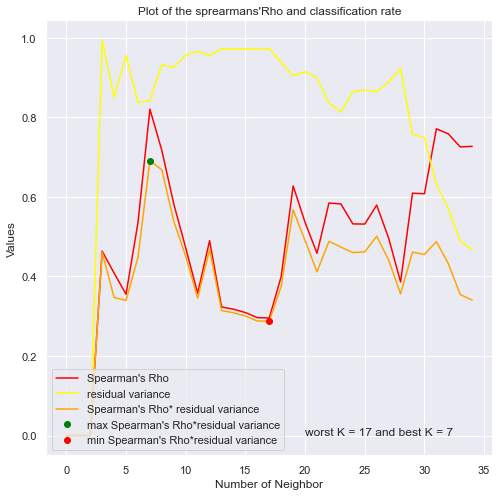

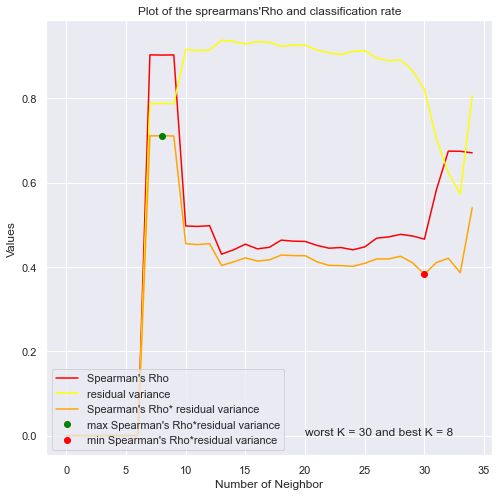

In [67]:
# the swiss roll
Dataset_swissroll, color = datasets.make_swiss_roll(n_samples=1000,noise = 0.0)
Best_N_LLE,Worst_N_LLE = num_neigh(Dataset_swissroll,2, "standard")
Best_N_HLLE,Worst_N_HLLE = num_neigh(Dataset_swissroll,2, "hessian")


Best projection LLE
Done. Reconstruction error: 2.74641e-08
Number of neighbor: 7
worst projection LLE 
Done. Reconstruction error: 4.73326e-07
Number of neighbor: 17


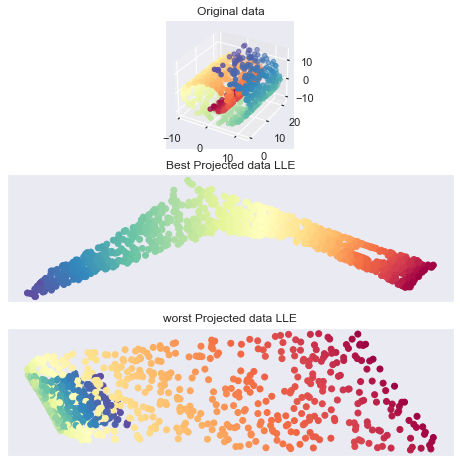

In [68]:
# LLE 

print("Best projection LLE")
X_B, err = manifold.locally_linear_embedding(Dataset_swissroll, n_neighbors=Best_N_LLE,n_components=2)
print("Done. Reconstruction error: %g" % err)
print("Number of neighbor: %g" % Best_N_LLE)
print("worst projection LLE ")
X_W, err = manifold.locally_linear_embedding(Dataset_swissroll, n_neighbors=Worst_N_LLE,n_components=2)
print("Done. Reconstruction error: %g" % err)
print("Number of neighbor: %g" % Worst_N_LLE)

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(311, projection='3d')
ax.scatter(Dataset_swissroll[:, 0], Dataset_swissroll[:, 1], Dataset_swissroll[:, 2], c=color, cmap=plt.cm.Spectral)
ax.set_title("Original data")

ax = fig.add_subplot(312)
ax.scatter(X_B[:, 0], X_B[:, 1], c=color, cmap=plt.cm.Spectral)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('Best Projected data LLE')

ax = fig.add_subplot(313)
ax.scatter(X_W[:, 0], X_W[:, 1], c=color, cmap=plt.cm.Spectral)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('worst Projected data LLE')
plt.show()

Best projection HLLE
Done. Reconstruction error: 1.26955e-06
Number of neighbor: 8
worst projection HLLE
Done. Reconstruction error: 0.0116921
Number of neighbor: 30


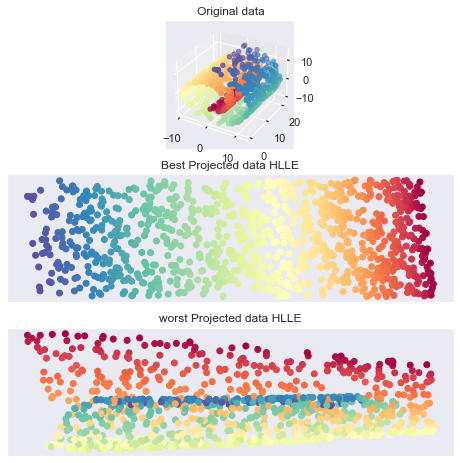

In [69]:
# HLLE 

print("Best projection HLLE")
X_B, err = manifold.locally_linear_embedding(Dataset_swissroll, n_neighbors=Best_N_HLLE,n_components=2,method = "hessian")
print("Done. Reconstruction error: %g" % err)
print("Number of neighbor: %g" % Best_N_HLLE)
print("worst projection HLLE" )
X_W, err = manifold.locally_linear_embedding(Dataset_swissroll, n_neighbors=Worst_N_HLLE,n_components=2,method = "hessian")
print("Done. Reconstruction error: %g" % err)
print("Number of neighbor: %g" % Worst_N_HLLE)

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(311, projection='3d')
ax.scatter(Dataset_swissroll[:, 0], Dataset_swissroll[:, 1], Dataset_swissroll[:, 2], c=color, cmap=plt.cm.Spectral)
ax.set_title("Original data")

ax = fig.add_subplot(312)
ax.scatter(X_B[:, 0], X_B[:, 1], c=color, cmap=plt.cm.Spectral)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('Best Projected data HLLE')

ax = fig.add_subplot(313)
ax.scatter(X_W[:, 0], X_W[:, 1], c=color, cmap=plt.cm.Spectral)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('worst Projected data HLLE')
plt.show()


# Toy data with noise

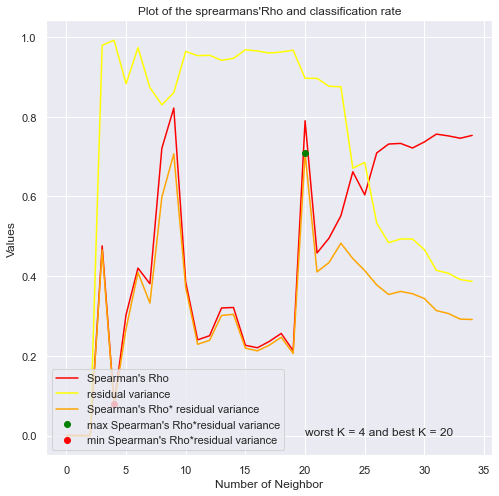

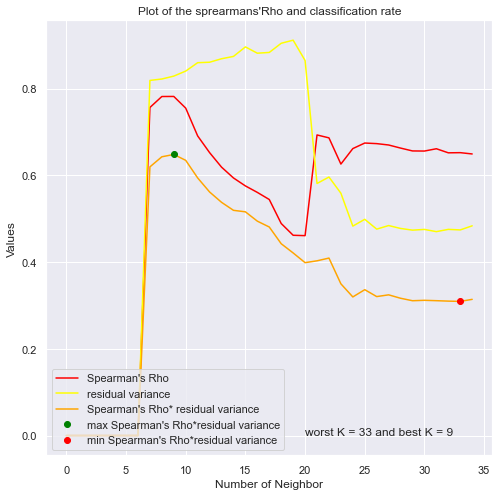

In [74]:
# the swiss roll
Dataset_swissroll, color = datasets.make_swiss_roll(n_samples=1000,noise = 0.4)
Best_N_LLE,Worst_N_LLE = num_neigh(Dataset_swissroll,2, "standard")
Best_N_HLLE,Worst_N_HLLE = num_neigh(Dataset_swissroll,2, "hessian")


Best projection LLE
Done. Reconstruction error: 1.65384e-07
Number of neighbor: 20
worst projection LLE 
Done. Reconstruction error: 5.62889e-17
Number of neighbor: 4


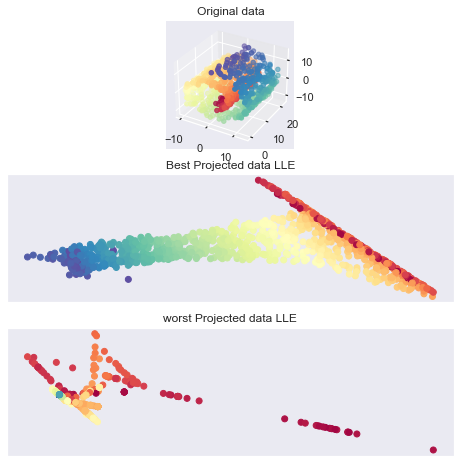

In [75]:
# LLE 

print("Best projection LLE")
X_B, err = manifold.locally_linear_embedding(Dataset_swissroll, n_neighbors=Best_N_LLE,n_components=2)
print("Done. Reconstruction error: %g" % err)
print("Number of neighbor: %g" % Best_N_LLE)
print("worst projection LLE ")
X_W, err = manifold.locally_linear_embedding(Dataset_swissroll, n_neighbors=Worst_N_LLE,n_components=2)
print("Done. Reconstruction error: %g" % err)
print("Number of neighbor: %g" % Worst_N_LLE)

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(311, projection='3d')
ax.scatter(Dataset_swissroll[:, 0], Dataset_swissroll[:, 1], Dataset_swissroll[:, 2], c=color, cmap=plt.cm.Spectral)
ax.set_title("Original data")

ax = fig.add_subplot(312)
ax.scatter(X_B[:, 0], X_B[:, 1], c=color, cmap=plt.cm.Spectral)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('Best Projected data LLE')

ax = fig.add_subplot(313)
ax.scatter(X_W[:, 0], X_W[:, 1], c=color, cmap=plt.cm.Spectral)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('worst Projected data LLE')
plt.show()

Best projection HLLE
Done. Reconstruction error: 0.000170299
Number of neighbor: 9
worst projection HLLE
Done. Reconstruction error: 0.0465385
Number of neighbor: 33


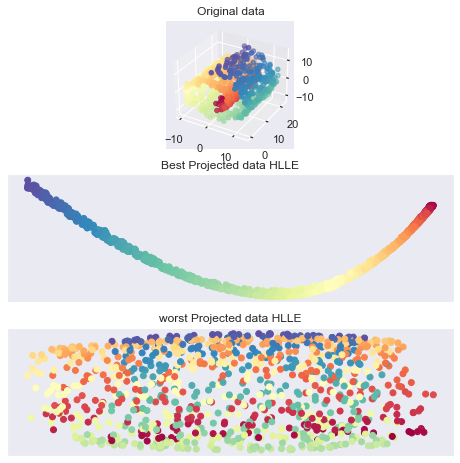

In [76]:
# HLLE 

print("Best projection HLLE")
X_B, err = manifold.locally_linear_embedding(Dataset_swissroll, n_neighbors=Best_N_HLLE,n_components=2,method = "hessian")
print("Done. Reconstruction error: %g" % err)
print("Number of neighbor: %g" % Best_N_HLLE)
print("worst projection HLLE" )
X_W, err = manifold.locally_linear_embedding(Dataset_swissroll, n_neighbors=Worst_N_HLLE,n_components=2,method = "hessian")
print("Done. Reconstruction error: %g" % err)
print("Number of neighbor: %g" % Worst_N_HLLE)

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(311, projection='3d')
ax.scatter(Dataset_swissroll[:, 0], Dataset_swissroll[:, 1], Dataset_swissroll[:, 2], c=color, cmap=plt.cm.Spectral)
ax.set_title("Original data")

ax = fig.add_subplot(312)
ax.scatter(X_B[:, 0], X_B[:, 1], c=color, cmap=plt.cm.Spectral)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('Best Projected data HLLE')

ax = fig.add_subplot(313)
ax.scatter(X_W[:, 0], X_W[:, 1], c=color, cmap=plt.cm.Spectral)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('worst Projected data HLLE')
plt.show()

# OUR dataset

In [ ]:
# reading csv files
data =  pd.read_csv('../semeion.data',header=None, sep=" ")
data = data.drop(columns=[266])
# 256 first columns is pixel and the last 10 is to say which number is it.
# 1593 data
data.shape


In [ ]:
# keep just the pixel for visualization
images = data.truncate(before="0", after="255", axis="columns")
image =[0]*1593
image_reshape =[0]*1593
for i in range (0,1592):
    image[i] = np.array(images.iloc[i])
    image_reshape[i] = np.reshape(image[i],(16,16))

In [ ]:
#plot each image
for i in range (0,1592):
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.imshow(image_reshape[i], cmap=plt.cm.gray)
    plt.show()